# Wczytanie danych


In [1]:
# install Java8
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# download spark2.4.5
!wget -q https://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
# unzip it
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
# install findspark
!pip install -q findspark
# Google Colab has Java 11 available, test it using below command -
!ls /usr/lib/jvm
#install pyarrow
!pip install -U pyarrow

default-java		   java-11-openjdk-amd64     java-8-openjdk-amd64
java-1.11.0-openjdk-amd64  java-1.8.0-openjdk-amd64
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 35.4 MB 396 kB/s 
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 6.0.1
    Uninstalling pyarrow-6.0.1:
      Successfully uninstalled pyarrow-6.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.17.9 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 10.0.0 which is incompatible.
db-dtypes 1.0.4 requires pyarrow<10.0dev,>=3.0.0, but you have pyarrow 10.0.0 which is incompatible.


In [2]:
import os
import findspark

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
spark_params = {
"spark.executor.memory" : "4g",
"spark.driver.memory": "4g",
"spark.memory.fraction": "0.9"}
for param, value in spark_params.items():
  spark.conf.set(param, value)
spark

In [3]:
!wget "https://datasets.imdbws.com/name.basics.tsv.gz"
!wget "https://datasets.imdbws.com/title.akas.tsv.gz"
!wget "https://datasets.imdbws.com/title.basics.tsv.gz"
!wget "https://datasets.imdbws.com/title.crew.tsv.gz"
!wget "https://datasets.imdbws.com/title.episode.tsv.gz"
!wget "https://datasets.imdbws.com/title.principals.tsv.gz"
!wget "https://datasets.imdbws.com/title.ratings.tsv.gz"

title_ratings = spark.read.csv("title.ratings.tsv.gz", sep='\t', header=True)
title_principals = spark.read.csv("title.principals.tsv.gz", sep='\t',header=True)
title_episode = spark.read.csv("title.episode.tsv.gz", sep='\t', header=True)
title_crew = spark.read.csv("title.crew.tsv.gz", sep='\t', header=True)
title_basics = spark.read.csv("title.basics.tsv.gz", sep='\t', header=True)
title_akas = spark.read.csv("title.akas.tsv.gz", sep='\t', header=True)
name_basics = spark.read.csv("name.basics.tsv.gz", sep='\t', header=True)

--2022-11-16 19:17:11--  https://datasets.imdbws.com/name.basics.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.249.98.91, 13.249.98.61, 13.249.98.35, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.249.98.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236436122 (225M) [binary/octet-stream]
Saving to: ‘name.basics.tsv.gz’

name.basics.tsv.gz  100%[===================>] 225.48M   123MB/s    in 1.8s    

2022-11-16 19:17:13 (123 MB/s) - ‘name.basics.tsv.gz’ saved [236436122/236436122]

--2022-11-16 19:17:13--  https://datasets.imdbws.com/title.akas.tsv.gz
Resolving datasets.imdbws.com (datasets.imdbws.com)... 13.249.98.91, 13.249.98.61, 13.249.98.35, ...
Connecting to datasets.imdbws.com (datasets.imdbws.com)|13.249.98.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 287493068 (274M) [binary/octet-stream]
Saving to: ‘title.akas.tsv.gz’

title.akas.tsv.gz   100%[===================>] 274.17M   135MB

# Analiza wstępna


In [66]:
import pyspark.sql.functions as F
import plotnine as pn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Tabele

Nazwy tabel, kolumn i przykładowe wiersze

In [ ]:
print("title_ratings")
title_ratings.show(4)

print("title_principals")
title_principals.show(4)

print("title_episode")
title_episode.show(4)

print("title_crew")
title_crew.show(4)

print("title_basics")
title_basics.show(4)

print("title_akas")
title_akas.show(4)

print("name_basics")
name_basics.show(4)

title_ratings
+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.7|    1922|
|tt0000002|          5.8|     259|
|tt0000003|          6.5|    1734|
|tt0000004|          5.6|     174|
+---------+-------------+--------+
only showing top 4 rows

title_principals
+---------+--------+---------+---------------+--------------------+----------+
|   tconst|ordering|   nconst|       category|                 job|characters|
+---------+--------+---------+---------------+--------------------+----------+
|tt0000001|       1|nm1588970|           self|                  \N|  ["Self"]|
|tt0000001|       2|nm0005690|       director|                  \N|        \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|        \N|
|tt0000002|       1|nm0721526|       director|                  \N|        \N|
+---------+--------+---------+---------------+--------------------+----------+
only showing top 4 rows

title_e

## Podstawowe informacje

Poniżej znajdują się podstawowe informacje dotyczące poszczególnych tabel. Warto zwrócić uwagę na kolumnę *liczba_nulli*, ponieważ w danych oprócz wartości brakujących, znajdują się również wartości \N, które oznaczają brak informacji z powodu natury poszczególnych cech rozpatrywanych produkcji. 
Przykłady :
- produkcja seriali zaczyna się i kończy w jakimś roku, filmy posiadają tylko datę produkcji, stąd wartości \N w kolumnie *endYear* dla filmów
- dla niektórych rodzajów produkcji, jak np. gry wideo, kolumna *RunruntimeMinutes* przyjmuje tylko wartości \N, ponieważ gry nie mają określonego czasu trwania
- jeżeli w *title_akas* wybierzemy tylko te wiersze, gdzie *isOriginalTitle* = 1, otrzymamy wartości \N w kolumnach *region* oraz *language*, ponieważ z założenia jest to tabela z tytułami filmów w innym niż oryginalnym języku




In [ ]:
table_name = ["title_ratings","title_principals","title_episode","title_crew","title_basics","title_akas","name_basics"]

rows_count = [title_ratings.count(),title_principals.count(),title_episode.count(),
              title_crew.count(),title_basics.count(),title_akas.count(),name_basics.count()]
              
columns_count = [len(title_ratings.columns),len(title_principals.columns),len(title_episode.columns),
                 len(title_crew.columns),len(title_basics.columns),len(title_akas.columns),len(name_basics.columns)]

duplicated_rows = [title_ratings.groupBy(title_ratings.columns).count().where(F.col('count') > 1).select(F.sum('count')).count() - 1,
title_principals.groupBy(title_principals.columns).count().where(F.col('count') > 1).select(F.sum('count')).count() - 1,
title_episode.groupBy(title_episode.columns).count().where(F.col('count') > 1).select(F.sum('count')).count() - 1,
title_crew.groupBy(title_crew.columns).count().where(F.col('count') > 1).select(F.sum('count')).count() - 1,
title_basics.groupBy(title_basics.columns).count().where(F.col('count') > 1).select(F.sum('count')).count() - 1,
title_akas.groupBy(title_akas.columns).count().where(F.col('count') > 1).select(F.sum('count')).count() - 1,
name_basics.groupBy(name_basics.columns).count().where(F.col('count') > 1).select(F.sum('count')).count() - 1]

null_count = [rows_count[0] - title_ratings.dropna().count(),rows_count[1] - title_principals.dropna().count(),
              rows_count[2] - title_episode.dropna().count(),
              rows_count[3] - title_crew.dropna().count(),
              rows_count[4] - title_basics.dropna().count(),
              rows_count[5] - title_akas.dropna().count(),rows_count[6] - name_basics.dropna().count()]

info_table = pd.DataFrame(data = {
'nazwa_tabeli': table_name,
"liczba_wierszy": rows_count,
"liczba_kolumn":columns_count,
"zduplikowane_wiersze":duplicated_rows,
"liczba_nulli":null_count
})

display(info_table)



,nazwa_tabeli,liczba_wierszy,liczba_kolumn,zduplikowane_wiersze,liczba_nulli
0,title_ratings,1245812,3,0,0
1,title_principals,52954205,6,0,0
2,title_episode,7066769,4,0,0
3,title_crew,9360108,3,0,0
4,title_basics,9360108,9,0,10
5,title_akas,33832793,8,0,3
6,name_basics,12062746,6,0,2605945


Tabele, która wydają się być najbardziej istotne w dalszej pracy z bazą, to *title_basics* i *title_ratings*.

### \N w title_basics i title_ratings

In [72]:
N_basics_count = []
for i in range(len(title_basics.columns)):
  N_basics_count.append(title_basics.where(F.col(title_basics.columns[i]) == "\\N").count())

N_ratings_count = []
for i in range(len(title_ratings.columns)):
  N_ratings_count.append(title_ratings.where(F.col(title_ratings.columns[i]) == "\\N").count())

N_basics = pd.DataFrame(data = {"nazwa_kolumny":title_basics.columns, "liczba wartości \\N":N_basics_count})

N_ratings = pd.DataFrame(data = {"nazwa_kolumny":title_ratings.columns, "liczba wartości \\N":N_ratings_count})

print("wartości \\N - title_basics")
display(N_basics)
print("wartości \\N - title_ratings")
display(N_ratings)

wartości \N - title_basics


,nazwa_kolumny,liczba wartości \N
0,tconst,0
1,titleType,0
2,primaryTitle,0
3,originalTitle,0
4,isAdult,1
5,startYear,1258269
6,endYear,9276187
7,runtimeMinutes,6782750
8,genres,430596


wartości \N - title_ratings


,nazwa_kolumny,liczba wartości \N
0,tconst,0
1,averageRating,0
2,numVotes,0


# Wykresy

Poniższe wykresy i tabele mogą okazać się pomocne w celu np. zbadania zbilansowania danych

## Rok produkcji

Dane przedstawione na wykresach pochodzą z lat 1874 - 2021. Produkcje z roku 2022 nie są uwzględnione, ponieważ rok 2022 wciąż trwa.

Lata z największą ilością produkcji


,startYear,count
114,2021,436615
53,2018,424369
23,2017,421203
21,2019,413372
7,2016,399447
8,2020,388032
123,2015,376745
27,2014,358138
31,2013,338532
9,2012,314934


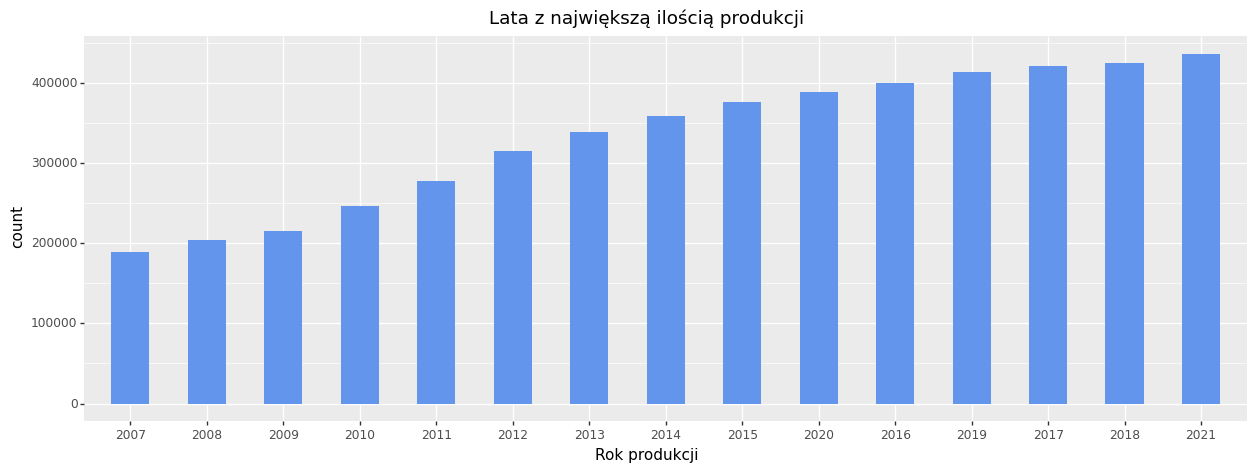

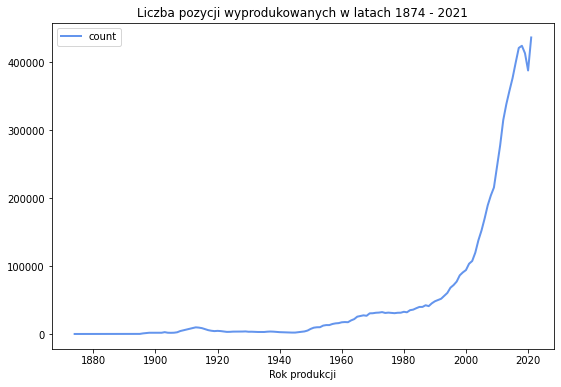

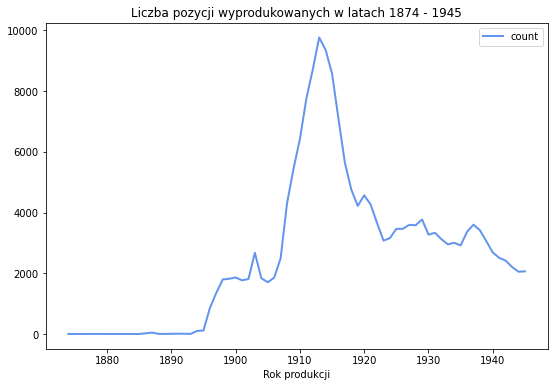

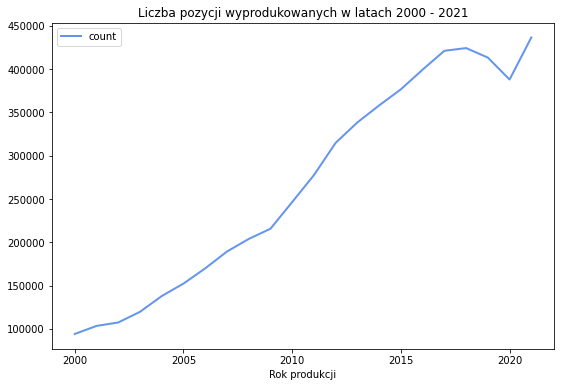

In [5]:
data_start_year_count = title_basics.groupBy("startYear").count().where(F.col('startYear') < 2022)
data_start_year_count_pd = data_start_year_count.toPandas().astype(int)

head_data_start_year_count_pd = data_start_year_count_pd.sort_values(by = ['count'],ascending = False).head(15)

g1 = pn.ggplot(head_data_start_year_count_pd) + pn.aes(x = 'reorder(startYear, count)', y = "count" ) +  pn.geom_col(fill = "cornflowerblue", width = 0.5)+ pn.theme(
figure_size=(15 ,5)) + pn.ggtitle('Lata z największą ilością produkcji') + pn.xlab("Rok produkcji")
g1.draw()

print("Lata z największą ilością produkcji")
display(head_data_start_year_count_pd)

data_start_year_count_pd.sort_values(by = ["startYear"]).plot(x = "startYear", y = "count", title = "Liczba pozycji wyprodukowanych w latach 1874 - 2021", 
                              figsize =(9, 6), linewidth=2,color = "cornflowerblue", xlabel = "Rok produkcji")

data_start_year_count_pd.where(data_start_year_count_pd['startYear'] < 1946).sort_values(by = ["startYear"]).plot(x = "startYear", y = "count", 
                              title = "Liczba pozycji wyprodukowanych w latach 1874 - 1945", figsize =(9, 6), linewidth=2,color = "cornflowerblue", xlabel = "Rok produkcji")

data_start_year_count_pd.where(data_start_year_count_pd['startYear'] > 1999).sort_values(by = ["startYear"]).plot(x = "startYear", y = "count", 
                              title = "Liczba pozycji wyprodukowanych w latach 2000 - 2021", figsize =(9, 6), linewidth=2,color = "cornflowerblue", xlabel = "Rok produkcji")

## Czas trwania

,interval,count
0,"[0, 10]",418417
1,"[11, 20]",342475
2,"[21, 30]",616454
3,"[31, 40]",87230
4,"[41, 50]",322620
5,"[51, 60]",227048
6,"[61, 70]",60662
7,"[71, 80]",76575
8,"[81, 90]",147988
9,"[91, 100]",99967


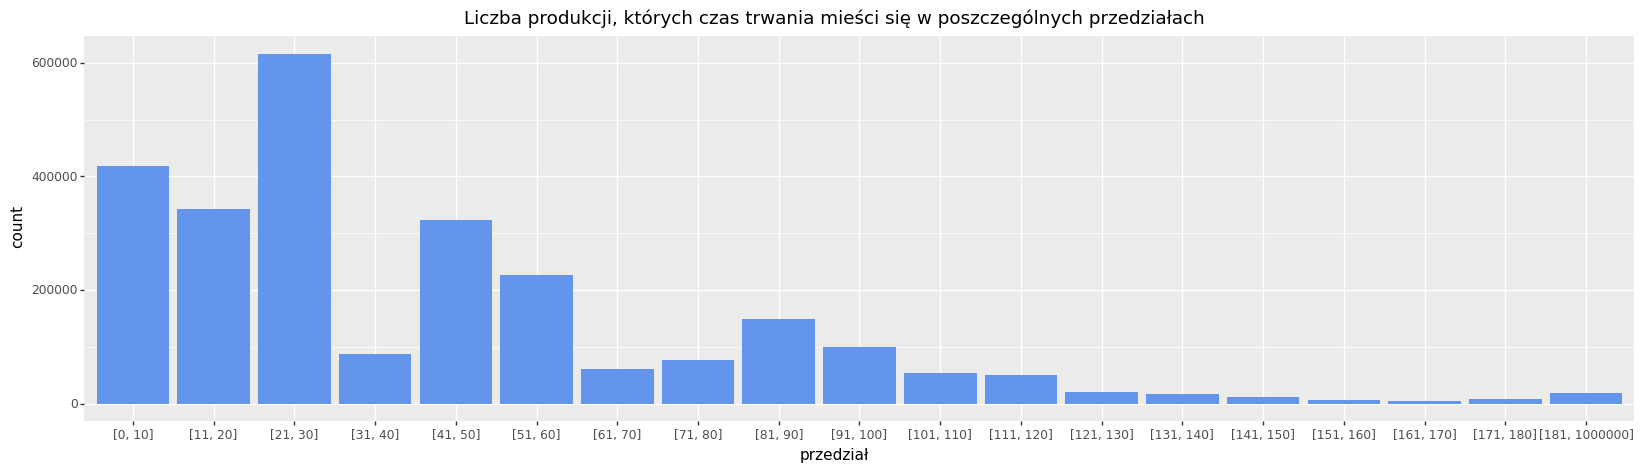

In [67]:
runtime_count = title_basics.filter(F.col("runtimeMinutes").cast("int").isNotNull()).groupBy("runtimeMinutes").count()
runtime_count_pd = runtime_count.toPandas()

intervals = [[[0,10],0]]
for i in range(1,18):
  intervals.append([[10*i + 1,10*i+10],0])
intervals.append([[181,1000000],0])

runtime_count_np = runtime_count_pd.sort_values(by = ["runtimeMinutes"]).to_numpy()

for i in range(len(runtime_count_np)):
  for k in range(len(intervals)):
    if int(runtime_count_np[i][0]) in range(intervals[k][0][0],intervals[k][0][1] + 1):
      intervals[k][1] += runtime_count_np[i][1]

for k in range(len(intervals)):
  intervals[k][0] = str(intervals[k][0])

intervals_pd = pd.DataFrame(intervals, columns = ["interval","count"])

index = list(range(len(intervals_pd)))
intervals_pd["index"] = index

g2 = pn.ggplot(intervals_pd) + pn.aes(x = 'reorder(interval, index )', y = "count" ) +  pn.geom_col(fill = "cornflowerblue")+ pn.theme(
figure_size=(20 ,5)) +pn.ggtitle('Liczba produkcji, których czas trwania mieści się w poszczególnych przedziałach') + pn.xlab("przedział")
g2.draw() 

display(intervals_pd.drop(['index'], axis=1))

## Adult/NonAdult

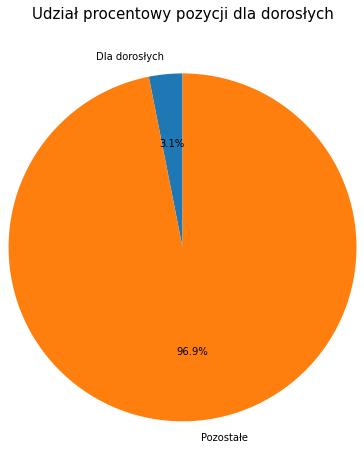

,rodzaj,count
0,Dla dorosłych,291274
1,Pozostałe,9083536


In [68]:
filtered_by_isAdult = title_basics.filter(F.col('isAdult') == 1).count()
filtered_by_isnonAdult = title_basics.filter(F.col('isAdult') == 0).count()

plt.pie([filtered_by_isAdult, filtered_by_isnonAdult],labels = ['Dla dorosłych', 'Pozostałe'], autopct = '%1.1f%%', radius = 2, startangle = 90)
plt.title("Udział procentowy pozycji dla dorosłych", pad = 120, fontsize=15)
plt.show()

display(pd.DataFrame(data = {"rodzaj" : ['Dla dorosłych', 'Pozostałe'], "count" : [filtered_by_isAdult,filtered_by_isnonAdult]}))

## Oceny

,interval,count
0,"[1, 1.5]",2891
1,"[1.6, 2.0]",2596
2,"[2.1, 2.5]",4570
3,"[2.6, 3.0]",7221
4,"[3.1, 3.5]",11361
5,"[3.6, 4.0]",18205
6,"[4.1, 4.5]",27405
7,"[4.6, 5.0]",42698
8,"[5.1, 5.5]",63489
9,"[5.6, 6.0]",97451


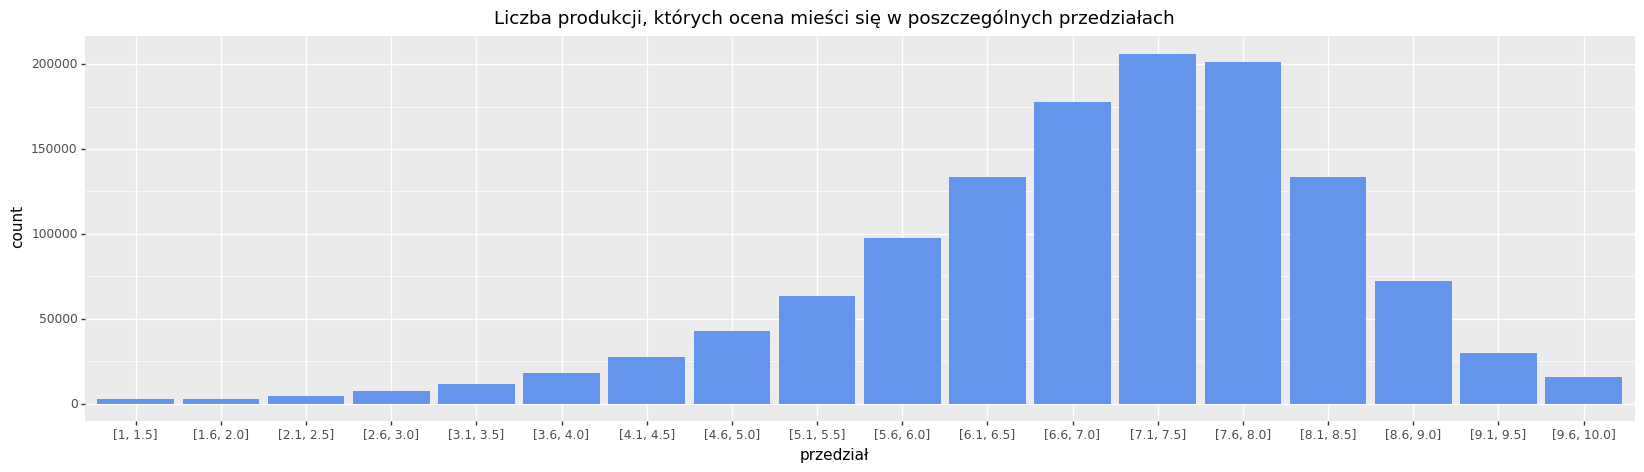

In [69]:
rate_count = title_ratings.drop("tconst").groupBy("averageRating").count()
rate_count_np = rate_count.toPandas().to_numpy()

intervals_1 = [[[1,1.5],0]]
for i in range(3,20):
  intervals_1.append([[i/2 + 0.1,(i+1)/2],0])

for i in range(len(rate_count_np)):
  for k in range(len(intervals_1)):
    if (float(rate_count_np[i][0]) <=  intervals_1[k][0][1] and float(rate_count_np[i][0]) >= intervals_1[k][0][0]):
      intervals_1[k][1] += rate_count_np[i][1]

for k in range(len(intervals_1)):
  intervals_1[k][0] = str(intervals_1[k][0])

intervals_1_pd = pd.DataFrame(intervals_1, columns = ["interval","count"])

g3 = pn.ggplot(intervals_1_pd) + pn.aes(x = "interval", y = "count" ) +  pn.geom_col(fill = "cornflowerblue")+ pn.theme(
figure_size=(20 ,5)) + pn.ggtitle('Liczba produkcji, których ocena mieści się w poszczególnych przedziałach') + pn.xlab("przedział")
g3.draw()

display(intervals_1_pd)



## Typy

,titleType,count
3,tvPilot,2
9,tvShort,10739
8,videoGame,32783
6,tvSpecial,39087
1,tvMiniSeries,45979
2,tvMovie,138290
0,tvSeries,234136
7,video,267228
5,movie,627193
10,short,900073


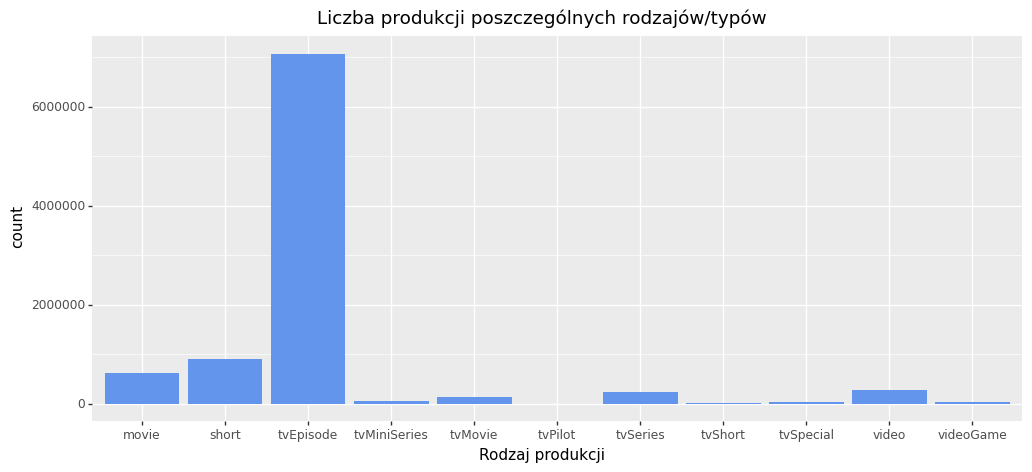

In [70]:
data_title_type_count = title_basics.groupBy("titleType").count()
data_title_type_count_pd = data_title_type_count.toPandas().sort_values(by = ["count"])

g4 = pn.ggplot(data_title_type_count_pd) + pn.aes(x = "titleType", y = "count") + pn.geom_col(fill = "cornflowerblue")+ pn.theme(
figure_size=(12 ,5)) + pn.ggtitle('Liczba produkcji poszczególnych rodzajów/typów') + pn.xlab("Rodzaj produkcji")
g4.draw()

display(data_title_type_count_pd)

## Gatunki

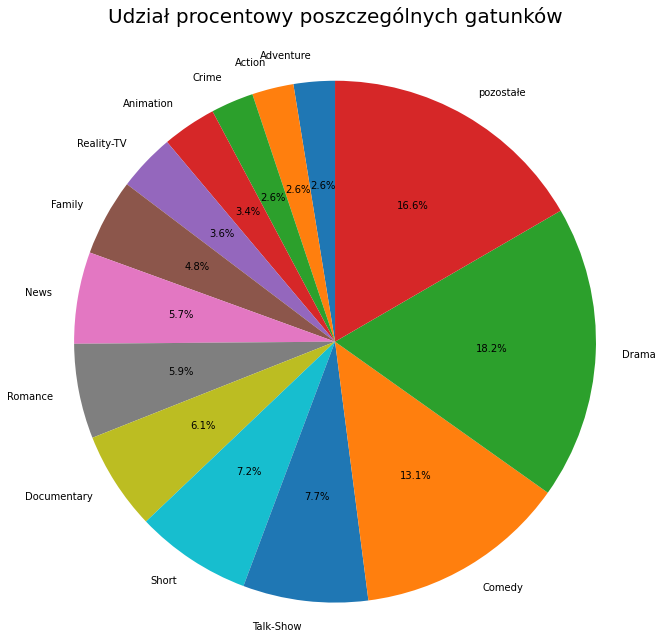

,genres,count
8,Action,373409
0,Adult,287449
2,Adventure,370512
27,Animation,485948
3,Biography,102010
24,Comedy,1904146
6,Crime,384135
10,Documentary,884748
15,Drama,2638329
11,Family,689982


In [71]:
data_genres_count = title_basics.filter(F.col('genres') != "\\N").groupBy("genres").count()
data_genres_count_np = data_genres_count.toPandas().to_numpy()

genres_list = []
for k in range(len(data_genres_count_np)):
  if data_genres_count_np[k][0] != None:
    for i in range(len(data_genres_count_np[k][0].split(','))):
      genres_list.append(data_genres_count_np[k][0].split(',')[i])

genres_list = list(set(genres_list))

for i in range(len(genres_list)):
  genres_list[i] = [genres_list[i],0]
  for k in range(len(data_genres_count_np)):
    if data_genres_count_np[k][0] != None:
      if genres_list[i][0] in data_genres_count_np[k][0].split(','):
        genres_list[i][1] = genres_list[i][1] + data_genres_count_np[k][1]

genres_list_pd = pd.DataFrame(genres_list, columns = ['genres','count']).sort_values(by = ["genres"])

drop_col_index = list(range(15)) # ostatnie 15 gatunków z najmniejszą ilością produkcji figuruje na wykresie jako "pozostałe"
drop_genres_list = genres_list_pd.sort_values(by = ["count"]).drop(genres_list_pd.sort_values(by = ["count"]).index[drop_col_index])

drop_genres_list = drop_genres_list.append({'genres': 'pozostałe', 'count': int(genres_list_pd.sum()[1] - drop_genres_list.sum()[1])},ignore_index=True)

plt.pie(drop_genres_list['count'], labels= drop_genres_list['genres'], autopct='%1.1f%%', radius = 3, startangle=90)
plt.title("Udział procentowy poszczególnych gatunków",pad = 210, fontsize = 20)
plt.show()

display(genres_list_pd)